<a href="https://colab.research.google.com/github/jescuti/deepplant/blob/main/deepplant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run this to clone the repo:

In [1]:
!git clone https://github.com/jescuti/deepplant.git

Cloning into 'deepplant'...
remote: Enumerating objects: 42337, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 42337 (delta 58), reused 119 (delta 41), pack-reused 42193 (from 4)
Receiving objects: 100% (42337/42337), 514.74 MiB | 33.15 MiB/s, done.
Resolving deltas: 100% (10679/10679), done.


In [2]:
%cd deepplant
%cd preprocessing

/content/deepplant
/content/deepplant/preprocessing


Download SAM

In [5]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.4 MB/s eta 0:00:00


In [10]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

Setting up SAM!
Setting up automatic mask generation!
SAM is generating masks!
SAM found 72 masks in this image


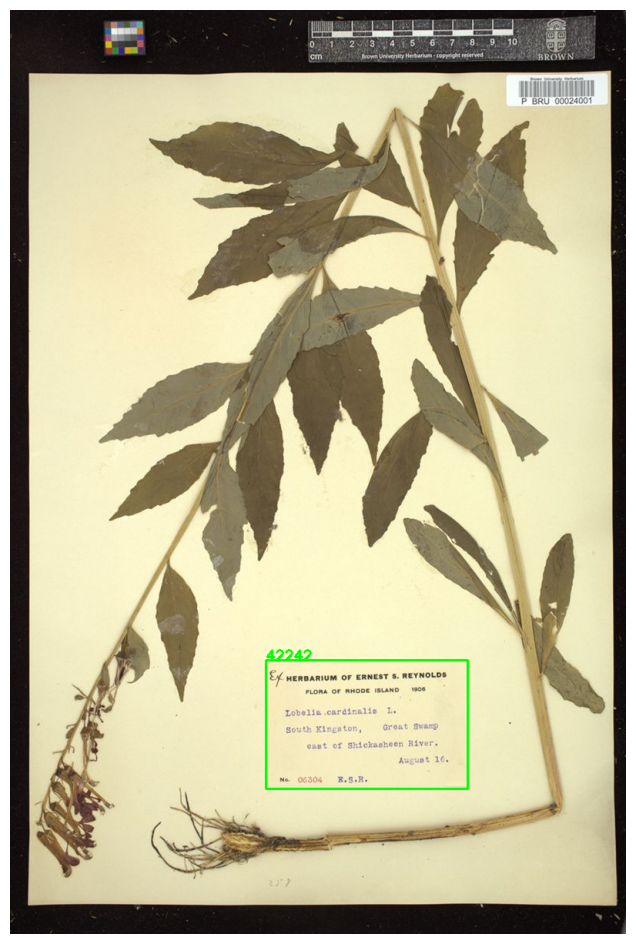

In [11]:
import torch
import cv2
import os
import supervision as sv
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor

sam_checkpoint = os.path.join("{HOME}", "weights", "sam_vit_h_4b8939.pth")
model_type = "vit_h"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("Setting up SAM!")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

print("Setting up automatic mask generation!")
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_offset=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100
    )

#Everything after this line should go in a for loop for generating
#multiple cropped images
img = cv2.imread('test-images/lobelia.jpg')

image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("SAM is generating masks!")

masks = mask_generator.generate(image_rgb)
print("SAM found "+str(len(masks))+" masks in this image")

labels = []
for mask in masks:
  bbox = mask["bbox"]
  x = bbox[0]
  y = bbox[1]
  w = bbox[2]
  h = bbox[3]
  #only return contours of a certain size
  if mask["area"] > 30000 and mask["area"] < 50000:
      cv2.putText(img, str(mask["area"]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
  labels.append(bbox)

sv.plot_image(img)

In [6]:
!python test.py

Setting up SAM!
Traceback (most recent call last):
  File "/content/deepplant/preprocessing/test.py", line 14, in <module>
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py", line 15, in build_sam_vit_h
    return _build_sam(
           ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py", line 105, in _build_sam
    state_dict = torch.load(f)
                 ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/serialization.py", line 1432, in load
    with _open_zipfile_reader(opened_file) as opened_zipfile:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/serialization.py", line 763, in __init__
    super().__init__(torch._C.PyTorchFileReader(name_or_buffer))
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
